In [1]:
import xarray as xr
import geopandas as gpd
import pandas as pd
import numpy as np
import shapely.geometry
import shapely
import rasterio
import rioxarray
from rasterio.features import shapes
from shapely.geometry import shape
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
xr_final_SI = xr.open_dataset('Output\\xr_SI_Landcover_beforefeedstock.nc')
print(xr_final_SI)

df_landuse_suitability_index = xr_final_SI.to_dataframe()
df_landuse_suitability_index.reset_index(inplace=True)
df_landuse_suitability_index = gpd.GeoDataFrame(df_landuse_suitability_index, geometry =gpd.points_from_xy(df_landuse_suitability_index['lon'],df_landuse_suitability_index['lat']))
df_landuse_suitability_index.crs = {'init': 'epsg:4326'}

print(df_landuse_suitability_index)

<xarray.Dataset>
Dimensions:     (lat: 5346, lon: 2985)
Coordinates:
  * lat         (lat) float64 5.615 5.618 5.621 5.624 ... 20.46 20.46 20.46
  * lon         (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6
Data variables:
    lccs_class  (lat, lon) int64 ...
    SI_BGEC     (lat, lon) int64 ...
    SI_Biomass  (lat, lon) int64 ...
    SI_Solar    (lat, lon) int64 ...
    SI_Wind     (lat, lon) int64 ...
    SI_BGWW     (lat, lon) int64 ...
    SI_MSW      (lat, lon) int64 ...
    SI_IEW      (lat, lon) int64 ...
                lat         lon  lccs_class  SI_BGEC  SI_Biomass  SI_Solar  \
0          5.615278   97.345833           0        0           0         0   
1          5.615278   97.348611           0        0           0         0   
2          5.615278   97.351389           0        0           0         0   
3          5.615278   97.354167           0        0           0         0   
4          5.615278   97.356944           0        0           0         0   

c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [3]:
## First, I try to create a bouadary of THialand for acquiring data##
thailandmap = gpd.read_file('Data\\tha_admbnda_adm1_rtsd_20220121\\tha_admbnda_adm1_rtsd_20220121.shp')
thailandmap.crs = {'init': 'epsg:4326'}
thailandmap['center'] = thailandmap['geometry'].centroid
thailandmap = thailandmap.drop(columns = 'geometry')
thailandmap = thailandmap.set_geometry('center')
thailandmap.crs = {'init': 'epsg:4326'}
print(thailandmap)

c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


    Shape_Leng  Shape_Area                   ADM1_EN          ADM1_TH  \
0     2.417227    0.131339                   Bangkok    กรุงเทพมหานคร   
1     1.695100    0.079262              Samut Prakan      สมุทรปราการ   
2     1.251111    0.053238                Nonthaburi          นนทบุรี   
3     1.884945    0.126983              Pathum Thani         ปทุมธานี   
4     3.041716    0.213938  Phra Nakhon Si Ayutthaya  พระนครศรีอยุธยา   
..         ...         ...                       ...              ...   
72    5.192570    0.385879                     Trang             ตรัง   
73    3.257829    0.316268               Phatthalung           พัทลุง   
74    2.820830    0.160825                   Pattani          ปัตตานี   
75    4.839230    0.365448                      Yala             ยะลา   
76    3.456840    0.366648                Narathiwat         นราธิวาส   

   ADM1_PCODE  ADM1_REF  ADM1ALT1EN  ADM1ALT2EN  ADM1ALT1TH  ADM1ALT2TH  \
0        TH10       NaN         NaN         NaN 

C:\Users\EGAT\AppData\Local\Temp\ipykernel_14596\2495709284.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  thailandmap['center'] = thailandmap['geometry'].centroid
c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [4]:
df_landuse_suitability_index_2 = gpd.sjoin_nearest(df_landuse_suitability_index,thailandmap,how='left')
print('columns before drop = ',df_landuse_suitability_index_2.columns)

for i in df_landuse_suitability_index_2.columns:
    if i not in (['lat', 'lon', 'lccs_class','SI_Solar','SI_Wind', 'SI_BGEC', 'SI_Biomass', 'SI_BGWW',
       'SI_MSW', 'SI_IEW', 'ADM1_EN', 'ADM1_TH']):
        df_landuse_suitability_index_2 = df_landuse_suitability_index_2.drop(columns=i)

print('columns after drop = ',df_landuse_suitability_index_2.columns)
print(len(df_landuse_suitability_index_2))
print(df_landuse_suitability_index_2)

c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\array.py:364: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


columns before drop =  Index(['lat', 'lon', 'lccs_class', 'SI_BGEC', 'SI_Biomass', 'SI_Solar',
       'SI_Wind', 'SI_BGWW', 'SI_MSW', 'SI_IEW', 'geometry', 'index_right',
       'Shape_Leng', 'Shape_Area', 'ADM1_EN', 'ADM1_TH', 'ADM1_PCODE',
       'ADM1_REF', 'ADM1ALT1EN', 'ADM1ALT2EN', 'ADM1ALT1TH', 'ADM1ALT2TH',
       'ADM0_EN', 'ADM0_TH', 'ADM0_PCODE', 'date', 'validOn', 'validTo'],
      dtype='object')
columns after drop =  Index(['lat', 'lon', 'lccs_class', 'SI_BGEC', 'SI_Biomass', 'SI_Solar',
       'SI_Wind', 'SI_BGWW', 'SI_MSW', 'SI_IEW', 'ADM1_EN', 'ADM1_TH'],
      dtype='object')
15957810
                lat         lon  lccs_class  SI_BGEC  SI_Biomass  SI_Solar  \
0          5.615278   97.345833           0        0           0         0   
1          5.615278   97.348611           0        0           0         0   
2          5.615278   97.351389           0        0           0         0   
3          5.615278   97.354167           0        0           0         0   


In [5]:
print('no of province = ',len(df_landuse_suitability_index_2['ADM1_TH'].unique()))

no of province =  77


In [6]:
lccs_resolution = 300 ## meters
areapergrid = (300/1000) **2

## Agriculture ###
df_landuse_suitability_index_2['A_BGEC'] = 0
df_landuse_suitability_index_2['A_BGEC'].loc[df_landuse_suitability_index_2['lccs_class'].isin([10,11,12,20,30,40])] = areapergrid
df_landuse_suitability_index_2['A_BGEC']= df_landuse_suitability_index_2['A_BGEC'].astype('float64')

## Shrubs and Grassland ## Short vegetation and agriculture ## Natural Reserve
df_landuse_suitability_index_2['A_Biomass'] = 0
df_landuse_suitability_index_2['A_Biomass'].loc[df_landuse_suitability_index_2['lccs_class'].isin([110,130,120,121,122,200,201,202,140,150,151,152,153,10,11,12,20,30,40,180])] = areapergrid
df_landuse_suitability_index_2['A_Biomass']= df_landuse_suitability_index_2['A_Biomass'].astype('float64')

df_landuse_suitability_index_2['A_BGWW'] = 0
df_landuse_suitability_index_2['A_BGWW'].loc[df_landuse_suitability_index_2['lccs_class'].isin([10,11,12,20,30,40])] = areapergrid
df_landuse_suitability_index_2['A_BGWW']= df_landuse_suitability_index_2['A_BGWW'].astype('float64')

df_landuse_suitability_index_2['A_MSW'] = 0
df_landuse_suitability_index_2['A_MSW'].loc[df_landuse_suitability_index_2['lccs_class'].isin([190])] = areapergrid
df_landuse_suitability_index_2['A_MSW']= df_landuse_suitability_index_2['A_MSW'].astype('float64')

df_landuse_suitability_index_2['A_IEW'] = 0
df_landuse_suitability_index_2['A_IEW'].loc[df_landuse_suitability_index_2['lccs_class'].isin([190])] = areapergrid
df_landuse_suitability_index_2['A_IEW']= df_landuse_suitability_index_2['A_IEW'].astype('float64')

print(df_landuse_suitability_index_2)

feedstock = pd.read_excel('Data\\สรุปข้อมูลพลังงาน -  ฐานข้อมูลพลังงานประเทศไทย.xlsx',sheet_name='สรุปข้อมูลพลังงาน -  ฐานข้อมูลพ')
feedstock = feedstock.loc[feedstock['แหล่งพลังงานหลัก'].isin(['ชีวมวล','ก๊าซชีวภาพ','ขยะ'])]
feedstock.reset_index(inplace=True,drop=True)
print(feedstock)
print(len(feedstock['จังหวัด'].unique()))

list_province = df_landuse_suitability_index_2['ADM1_TH'].unique()
list_fueltype = feedstock['แหล่งพลังงานหลัก'].unique()
print(list_province)
print(list_fueltype)


C:\Users\EGAT\AppData\Local\Temp\ipykernel_14596\2873861754.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_landuse_suitability_index_2['A_BGEC'].loc[df_landuse_suitability_index_2['lccs_class'].isin([10,11,12,20,30,40])] = areapergrid
C:\Users\EGAT\AppData\Local\Temp\ipykernel_14596\2873861754.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_landuse_suitability_index_2['A_Biomass'].loc[df_landuse_suitability_index_2['lccs_class'].isin([110,130,120,121,122,200,201,202,140,150,151,152,153,10,11,12,20,30,40,180])] = areapergrid
C:\Users\EGAT\AppData\Local\Temp\ipykernel_14596\2873861754.py:15: SettingWithCo

                lat         lon  lccs_class  SI_BGEC  SI_Biomass  SI_Solar  \
0          5.615278   97.345833           0        0           0         0   
1          5.615278   97.348611           0        0           0         0   
2          5.615278   97.351389           0        0           0         0   
3          5.615278   97.354167           0        0           0         0   
4          5.615278   97.356944           0        0           0         0   
...             ...         ...         ...      ...         ...       ...   
15957805  20.462500  105.623611           0        0           0         0   
15957806  20.462500  105.626389           0        0           0         0   
15957807  20.462500  105.629167           0        0           0         0   
15957808  20.462500  105.631944           0        0           0         0   
15957809  20.462500  105.634722           0        0           0         0   

          SI_Wind  SI_BGWW  SI_MSW  SI_IEW    ADM1_EN ADM1_TH  

In [7]:
print("total A_Biomass = ", df_landuse_suitability_index_2['A_Biomass'].sum())
print("total A_BGEC = ", df_landuse_suitability_index_2['A_BGEC'].sum())
print("total A_BGWW = ", df_landuse_suitability_index_2['A_BGWW'].sum())
print("total A_MSW = ", df_landuse_suitability_index_2['A_MSW'].sum())
print("total A_IEW = ", df_landuse_suitability_index_2['A_IEW'].sum())

total A_Biomass =  136859.93999999986
total A_BGEC =  129829.14000000017
total A_BGWW =  129829.14000000017
total A_MSW =  751.8599999999997
total A_IEW =  751.8599999999997


In [8]:
for i in list_province:
    totalareaprovince = df_landuse_suitability_index_2['A_Biomass'].loc[(df_landuse_suitability_index_2['A_Biomass'] > 0) & (df_landuse_suitability_index_2['ADM1_TH'] == i)].sum() / areapergrid
    feedstockpergrid = (feedstock['ศักยภาพพลังงานทดแทน (ktoe)'].loc[(feedstock['จังหวัด'] == i) & (feedstock['แหล่งพลังงานหลัก'] == 'ชีวมวล')].values[0]) / totalareaprovince
    df_landuse_suitability_index_2['A_Biomass'].loc[(df_landuse_suitability_index_2['A_Biomass'] > 0) & (df_landuse_suitability_index_2['ADM1_TH'] == i)] = feedstockpergrid
    # print(i,(feedstock['ศักยภาพพลังงานทดแทน (ktoe)'].loc[(feedstock['จังหวัด'] == i) & (feedstock['แหล่งพลังงานหลัก'] == 'ชีวมวล')].values[0]), totalareaprovince, feedstockpergrid)

    totalareaprovince = df_landuse_suitability_index_2['A_BGEC'].loc[(df_landuse_suitability_index_2['A_BGEC'] > 0) &(df_landuse_suitability_index_2['ADM1_TH'] == i)].sum() / areapergrid
    feedstockpergrid = (feedstock['ศักยภาพพลังงานทดแทน (ktoe)'].loc[(feedstock['จังหวัด'] == i) & (feedstock['แหล่งพลังงานหลัก'] == 'ก๊าซชีวภาพ')].values[0]) / totalareaprovince
    df_landuse_suitability_index_2['A_BGEC'].loc[(df_landuse_suitability_index_2['A_BGEC'] > 0) & (df_landuse_suitability_index_2['ADM1_TH'] == i)] = feedstockpergrid

    totalareaprovince = df_landuse_suitability_index_2['A_BGWW'].loc[(df_landuse_suitability_index_2['A_BGWW'] > 0) & (df_landuse_suitability_index_2['ADM1_TH'] == i)].sum() / areapergrid
    feedstockpergrid = (feedstock['ศักยภาพพลังงานทดแทน (ktoe)'].loc[(feedstock['จังหวัด'] == i) & (feedstock['แหล่งพลังงานหลัก'] == 'ก๊าซชีวภาพ')].values[0]) / totalareaprovince
    df_landuse_suitability_index_2['A_BGWW'].loc[(df_landuse_suitability_index_2['A_BGWW'] > 0) & (df_landuse_suitability_index_2['ADM1_TH'] == i)] = feedstockpergrid

    totalareaprovince = df_landuse_suitability_index_2['A_MSW'].loc[(df_landuse_suitability_index_2['A_MSW'] > 0) &(df_landuse_suitability_index_2['ADM1_TH'] == i)].sum() / areapergrid
    feedstockpergrid = (feedstock['ศักยภาพพลังงานทดแทน (ktoe)'].loc[(feedstock['จังหวัด'] == i) & (feedstock['แหล่งพลังงานหลัก'] == 'ขยะ')].values[0]) / totalareaprovince
    df_landuse_suitability_index_2['A_MSW'].loc[(df_landuse_suitability_index_2['A_MSW'] > 0) & (df_landuse_suitability_index_2['ADM1_TH'] == i)] = feedstockpergrid

    totalareaprovince = df_landuse_suitability_index_2['A_IEW'].loc[(df_landuse_suitability_index_2['A_IEW'] > 0) &(df_landuse_suitability_index_2['ADM1_TH'] == i)].sum() / areapergrid
    feedstockpergrid = (feedstock['ศักยภาพพลังงานทดแทน (ktoe)'].loc[(feedstock['จังหวัด'] == i) & (feedstock['แหล่งพลังงานหลัก'] == 'ขยะ')].values[0]) / totalareaprovince
    df_landuse_suitability_index_2['A_IEW'].loc[(df_landuse_suitability_index_2['A_IEW'] > 0) & (df_landuse_suitability_index_2['ADM1_TH'] == i)] = feedstockpergrid

print("total A_Biomass = ", df_landuse_suitability_index_2['A_Biomass'].sum())
print("total A_BGEC = ", df_landuse_suitability_index_2['A_BGEC'].sum())
print("total A_BGWW = ", df_landuse_suitability_index_2['A_BGWW'].sum())
print("total A_MSW = ", df_landuse_suitability_index_2['A_MSW'].sum())
print("total A_IEW = ", df_landuse_suitability_index_2['A_IEW'].sum())

C:\Users\EGAT\AppData\Local\Temp\ipykernel_14596\3750733003.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_landuse_suitability_index_2['A_Biomass'].loc[(df_landuse_suitability_index_2['A_Biomass'] > 0) & (df_landuse_suitability_index_2['ADM1_TH'] == i)] = feedstockpergrid
C:\Users\EGAT\AppData\Local\Temp\ipykernel_14596\3750733003.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_landuse_suitability_index_2['A_BGEC'].loc[(df_landuse_suitability_index_2['A_BGEC'] > 0) & (df_landuse_suitability_index_2['ADM1_TH'] == i)] = feedstockpergrid
C:\Users\EGAT\AppData\Local\Temp\ipykernel_14596\3750733003.py:13: Set

total A_Biomass =  36459.309999999976
total A_BGEC =  1873.8300000000002
total A_BGWW =  1873.8300000000002
total A_MSW =  6438.65000000001
total A_IEW =  6438.65000000001


In [9]:
print(df_landuse_suitability_index_2)

                lat         lon  lccs_class  SI_BGEC  SI_Biomass  SI_Solar  \
0          5.615278   97.345833           0        0           0         0   
1          5.615278   97.348611           0        0           0         0   
2          5.615278   97.351389           0        0           0         0   
3          5.615278   97.354167           0        0           0         0   
4          5.615278   97.356944           0        0           0         0   
...             ...         ...         ...      ...         ...       ...   
15957805  20.462500  105.623611           0        0           0         0   
15957806  20.462500  105.626389           0        0           0         0   
15957807  20.462500  105.629167           0        0           0         0   
15957808  20.462500  105.631944           0        0           0         0   
15957809  20.462500  105.634722           0        0           0         0   

          SI_Wind  SI_BGWW  SI_MSW  SI_IEW    ADM1_EN ADM1_TH  

In [10]:
df_landuse_suitability_index_2 = df_landuse_suitability_index_2.drop(columns='ADM1_TH')
df_landuse_suitability_index_2 = df_landuse_suitability_index_2.set_index(['lat', 'lon'])
xr_areafeedstock = xr.Dataset.from_dataframe(df_landuse_suitability_index_2)
print(xr_areafeedstock.data_vars)
print(xr_areafeedstock)

Data variables:
    lccs_class  (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    SI_BGEC     (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    SI_Biomass  (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    SI_Solar    (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    SI_Wind     (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    SI_BGWW     (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    SI_MSW      (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    SI_IEW      (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    ADM1_EN     (lat, lon) object 'Phuket' 'Phuket' ... 'Bueng Kan' 'Bueng Kan'
    A_BGEC      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    A_Biomass   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    A_BGWW      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    A_MSW       (la

In [11]:
xr_areafeedstock.to_netcdf(path='Output\\xr_SI_Landcover.nc')

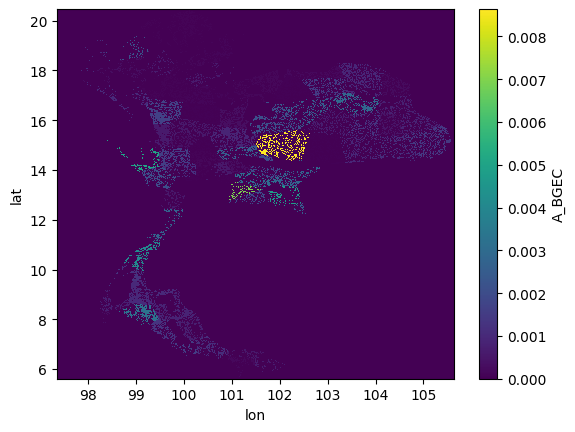

In [12]:
xr_areafeedstock['A_BGEC'].plot()

In [13]:
xr_areafeedstock = xr.open_dataset('Output\\xr_SI_Landcover.nc')

(103.09676066900005, 16.181673239000077, 104.24064016800008, 17.101957866000078)
<xarray.Dataset>
Dimensions:     (lat: 332, lon: 412)
Coordinates:
  * lat         (lat) float64 16.18 16.18 16.19 16.19 ... 17.09 17.1 17.1 17.1
  * lon         (lon) float64 103.1 103.1 103.1 103.1 ... 104.2 104.2 104.2
Data variables: (12/14)
    lccs_class  (lat, lon) int64 ...
    SI_BGEC     (lat, lon) int64 ...
    SI_Biomass  (lat, lon) int64 ...
    SI_Solar    (lat, lon) int64 ...
    SI_Wind     (lat, lon) int64 ...
    SI_BGWW     (lat, lon) int64 ...
    ...          ...
    ADM1_EN     (lat, lon) object ...
    A_BGEC      (lat, lon) float64 ...
    A_Biomass   (lat, lon) float64 ...
    A_BGWW      (lat, lon) float64 ...
    A_MSW       (lat, lon) float64 ...
    A_IEW       (lat, lon) float64 ...


c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


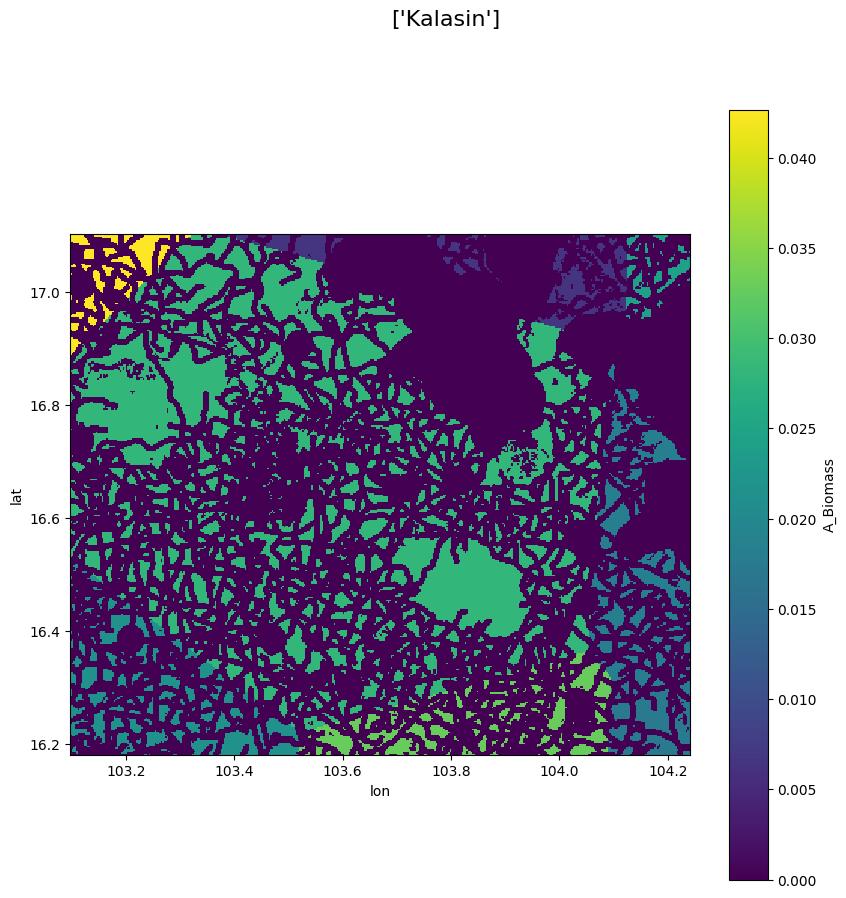

In [15]:
thailandmap = gpd.read_file('Data\\tha_admbnda_adm1_rtsd_20220121\\tha_admbnda_adm1_rtsd_20220121.shp')
thailandmap.crs = {'init': 'epsg:4326'}

province = 'Kalasin'
province = thailandmap.loc[thailandmap['ADM1_EN'] == province]
print(province.unary_union.bounds)
min_lon = province.unary_union.bounds[0]
max_lon = province.unary_union.bounds[2]
max_lat = province.unary_union.bounds[3]
min_lat = province.unary_union.bounds[1]

xr_buffer = xr_areafeedstock.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
print(xr_buffer)

fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle(province['ADM1_EN'].values, fontsize=16)
province.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
xr_buffer['A_Biomass'].plot(ax = ax,zorder = 1)